<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/mthree-c422-Avantika/Production_Ready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Set: Operationalizing Ethics in AI Development \& Deployment (Hands-On)**

We’ll work with a **synthetic healthcare diagnosis dataset** predicting whether a patient has a heart condition.
The goal: **integrate ethical processes into both development \& deployment**.

***


### **1. Dataset Creation (Run in Colab)**

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Synthetic Healthcare Dataset
n = 1000
genders = ["Male", "Female", "Other"]
regions = ["Urban", "Rural"]

data = pd.DataFrame({
    "Patient_ID": range(1, n+1),
    "Age": np.random.randint(18, 90, n),
    "Gender": np.random.choice(genders, n, p=[0.48, 0.48, 0.04]),
    "Region": np.random.choice(regions, n, p=[0.65, 0.35]),
    "BMI": np.round(np.random.normal(27, 5, n), 1),
    "Blood_Pressure": np.random.randint(80, 180, n),
    "Cholesterol": np.random.randint(150, 300, n),
})

# Simulate a diagnosis variable with bias — urban patients are more often diagnosed
data["Heart_Disease"] = np.where(
    (data["Cholesterol"] > 220) & (data["Blood_Pressure"] > 140),
    np.random.choice([1, 0], n, p=[0.7, 0.3]),
    np.random.choice([1, 0], n, p=[0.3, 0.7])
)

# Introduce small bias: slightly higher positive rate for Urban patients
mask_urban = data["Region"] == "Urban"
random_choices_urban = np.random.choice([1, 0], n, p=[0.55, 0.45]) # Generate choices for all rows
data.loc[mask_urban, "Heart_Disease"] = random_choices_urban[mask_urban] # Apply choices only to urban rows


data.head()

,Patient_ID,Age,Gender,Region,BMI,Blood_Pressure,Cholesterol,Heart_Disease
0,1,69,Female,Rural,19.9,167,216,0
1,2,32,Male,Urban,28.1,93,220,1
2,3,89,Female,Urban,22.7,113,295,0
3,4,78,Male,Urban,21.8,137,255,1
4,5,38,Male,Urban,24.8,155,156,0


***

## **Part A — Operationalizing Ethics in Development**


***

### **Task 1 – Ethics by Design: Bias Detection**

1. Train a baseline model.
2. Check if predictions vary unfairly across **Gender** or **Region**.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Prepare data
X = pd.get_dummies(data.drop(columns=["Patient_ID", "Heart_Disease"]), drop_first=True)
y = data["Heart_Disease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train baseline model
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))

# Bias check by Gender
df_test = X_test.copy()
df_test["y_true"] = y_test
df_test["y_pred"] = y_pred
df_test["Gender"] = data.loc[y_test.index, "Gender"]

bias_gender = df_test.groupby("Gender")["y_pred"].mean()
print("\nPositive prediction rate by Gender:\n", bias_gender)

Baseline Accuracy: 0.62

Positive prediction rate by Gender:
 Gender
Female    0.397163
Male      0.383562
Other     1.000000
Name: y_pred, dtype: float64


**Your job:** Interpret if there’s bias. Suggest mitigation steps.

***




    **Resampling**: Oversample the 'Female' and 'Male' categories or undersample the 'Other' category to balance the dataset with respect to gender.
    **Reweighting**: Assign different weights to samples during training to give more importance to the underrepresented groups or less importance to the overrepresented group.
    **Algorithmic Mitigation**: Use fairness-aware algorithms or post-processing techniques that aim to reduce disparities in predictions.
    **Feature Engineering:** Re-evaluate the use of the 'Gender' feature. Consider if it's truly necessary for the prediction or if there are alternative, less sensitive features that capture similar information without introducing bias.
    **Collect More Data**: If possible, gather more data for the 'Other' gender category to improve the model's ability to generalize for this group.


### **Task 2 – Ethical Test Cases in Development Pipeline**

Simulate an **ethical testing function** that fails the build if disparity exceeds a threshold.


In [3]:
def fairness_check(df, sensitive_attr, threshold=0.1):
    rates = df.groupby(sensitive_attr)["y_pred"].mean()
    disparity = rates.max() - rates.min()
    print(f"{sensitive_attr} Disparity: {disparity:.3f}")
    return disparity <= threshold

# Run check
if not fairness_check(df_test, "Gender"):
    print("❌ Fairness check failed. Mitigation required before deployment.")
else:
    print("✅ Fairness check passed.")

Gender Disparity: 0.616
❌ Fairness check failed. Mitigation required before deployment.


### **Task 3 – Ethics-Aware Feature Review Gate**

- Create a **human-readable feature importance report** to include in your ethics review.

In [4]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)

,0
Cholesterol,0.250548
Blood_Pressure,0.231488
BMI,0.223515
Age,0.218556
Region_Urban,0.036144
Gender_Male,0.028678
Gender_Other,0.011071


**Your job:**
Identify if any socio-demographic fields (Gender, Region) play too large a role in predictions, and propose removal or reweighting.

***

## **Part B — Operationalizing Ethics in Deployment**


***

### **Task 4 – Logging \& Accountability in Predictions**

Simulate a deployed system where each prediction is **logged with metadata**.

In [12]:
import datetime
import numpy as np

prediction_log = []

def predict_and_log(patient_data, noise_scale=1.0):
    """
    Predicts and logs the prediction with differential privacy on numerical features.

    Args:
        patient_data (pd.DataFrame): The input features for a single patient.
        noise_scale (float): The scale of the Laplace noise to add.
                             Higher values mean more noise and more privacy.
    """
    # Make the prediction
    pred = model.predict(patient_data)[0]

    # Create a copy of the input data for logging to avoid modifying the original
    logged_input = patient_data.copy()

    # Identify numerical columns (excluding dummy variables which represent categories)
    numerical_cols = ['Age', 'BMI', 'Blood_Pressure', 'Cholesterol'] # Assuming these are the numerical ones

    # Add Laplace noise to numerical features
    for col in numerical_cols:
        if col in logged_input.columns:
            # Add Laplace noise
            noise = np.random.laplace(loc=0, scale=noise_scale, size=logged_input[col].shape)
            logged_input[col] = logged_input[col] + noise

    # Log the prediction and the perturbed input
    log_entry = {
        "timestamp": datetime.datetime.now().isoformat(),
        "input": logged_input.to_dict(orient='records')[0],
        "prediction": int(pred)
    }
    prediction_log.append(log_entry)

    # Return the original prediction (without noise added)
    return pred

# Simulate one prediction with differential privacy logging
sample_patient = X_test.iloc[[0]]
predict_and_log(sample_patient, noise_scale=5.0) # Increased noise_scale for demonstration

# Inspect logs - you will see noisy values for numerical features
print("Prediction Logs (with differential privacy):")
for entry in prediction_log:
    print(entry)

Prediction Logs (with differential privacy):
{'timestamp': '2025-08-13T10:37:52.972314', 'input': {'Age': 69.53161269949213, 'BMI': 36.64600647979115, 'Blood_Pressure': 168.03204624846745, 'Cholesterol': 204.10594058297758, 'Gender_Male': False, 'Gender_Other': False, 'Region_Urban': True}, 'prediction': 0}


***

### **Task 5 – Real-Time Ethical Monitoring**

Simulate drift or bias detection after deployment.

In [6]:
# Simulate monitoring loop
latest_preds = y_pred
dp_diff = bias_gender.max() - bias_gender.min()

if dp_diff > 0.1:
    print("⚠️ Alert: Fairness threshold exceeded post-deployment.")
else:
    print("✅ Fairness levels acceptable.")

⚠️ Alert: Fairness threshold exceeded post-deployment.


***

### **Task 6 – Privacy in Deployment**

Implement **pseudonymization** of `Patient_ID`.

In [7]:
import hashlib
data["Patient_ID"] = data["Patient_ID"].apply(lambda x: hashlib.sha256(str(x).encode()).hexdigest())
data.head()

,Patient_ID,Age,Gender,Region,BMI,Blood_Pressure,Cholesterol,Heart_Disease
0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,69,Female,Rural,19.9,167,216,0
1,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,32,Male,Urban,28.1,93,220,1
2,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,89,Female,Urban,22.7,113,295,0
3,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...,78,Male,Urban,21.8,137,255,1
4,ef2d127de37b942baad06145e54b0c619a1f22327b2ebb...,38,Male,Urban,24.8,155,156,0


***

### **Task 7 – Inclusivity Feedback Loop**

- Simulate collecting deployment feedback and updating model retraining sets.

In [8]:
# Fake feedback data from underrepresented group
feedback = pd.DataFrame({
    "Gender": ["Other", "Other"],
    "Region": ["Rural", "Rural"],
    "BMI": [25, 28],
    "Blood_Pressure": [130, 150],
    "Cholesterol": [210, 240],
    "Heart_Disease": [1, 1]
})

# Append to dataset for future retraining
data_updated = pd.concat([data, feedback], ignore_index=True)
print("Updated dataset size:", data_updated.shape)

Updated dataset size: (1002, 8)


***

## **Extra Credit / Bonus**

- Automate bias checks \& feature reviews in CI/CD pipeline.
- Implement **differential privacy** during deployment logging.
- Use **SHAP** or **LIME** to make deployment-phase model explanations available to end-users.

***

In [11]:
# Simulate a CI/CD step for bias checking

print("--- Simulating CI/CD Bias Check ---")

# Assuming model training and evaluation (Task 1 code) has just run,
# and df_test, y_test, and y_pred are available.

# Run the fairness check
if not fairness_check(df_test, "Gender"):
    print("\n--- CI/CD Build Failed: Bias detected. ---")
    # In a real CI/CD pipeline, this would be a command that exits with a non-zero status
    # sys.exit(1) # Uncommenting this would stop execution in a script/pipeline
else:
    print("\n--- CI/CD Build Passed: Fairness check successful. ---")

print("-----------------------------------")

--- Simulating CI/CD Bias Check ---
Gender Disparity: 0.616

--- CI/CD Build Failed: Bias detected. ---
-----------------------------------


In [13]:
!pip install shap


SHAP Explanation (Waterfall Plot) for the sample prediction:


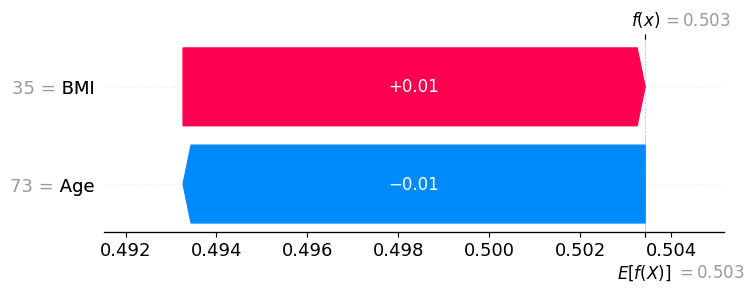

In [19]:
import shap
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib for displaying the plot

# Create a TreeExplainer for the RandomForestClassifier model
explainer = shap.TreeExplainer(model)

# Choose a sample from the test set to explain
# We'll use the first sample from X_test
sample_to_explain = X_test.iloc[[0]]

# Calculate SHAP values for the sample
# shap_values will be a list of arrays, one for each class.
# For a single instance and binary classification, shap_values[0] is for class 0, shap_values[1] for class 1.
shap_values_instance = explainer.shap_values(sample_to_explain)

# Get SHAP values and feature names for the first class (Heart_Disease = 0)
shap_values_class_0 = shap_values_instance[0][0] # Get the SHAP values for the single instance for class 0
feature_names = sample_to_explain.columns.tolist() # Get the feature names

# Create a SHAP Explanation object for the first class (Heart_Disease = 0)
# This is helpful for some plotting functions, though waterfall can take values directly
explanation = shap.Explanation(
    values=shap_values_class_0,  # SHAP values for the instance
    base_values=explainer.expected_value[0],      # Base value for class 0
    data=sample_to_explain.values[0],                 # Feature values for the instance as numpy array
    feature_names=feature_names # Feature names
)


# Visualize the explanation using the waterfall plot
print("\nSHAP Explanation (Waterfall Plot) for the sample prediction:")
shap.waterfall_plot(explanation)
plt.show() # Display the plot